In [117]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  


sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [3]:
end_date = datetime.strptime('2024-12-02', '%Y-%m-%d')
begin_date = end_date - timedelta(days=27)


query =f'''
SELECT 
user_id,
reg_date,
device,
t1.bonus_title AS bonus_title,
t2.bonus_title_new AS bonus_title_new,
created_at::date AS created_date,
CASE WHEN created_at='1970-01-01' THEN 0 ELSE 1 END trial_type
FROM datamarts.marketing_dash_distr AS t1
LEFT JOIN datamarts.mekhtiev_bonus_distr AS t2
on t1.bonus_title=t2.bonus_title_old
WHERE reg_date BETWEEN '{begin_date.date()}' AND '{end_date.date()}'

                    '''

df = execute(query,user = 'kmekhtiev')
df['reg_date'] = df['reg_date'].astype('datetime64[ns]')

Время выполнения функции: 1.7042 секунд



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32519 entries, 0 to 32518
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          32519 non-null  object        
 1   reg_date         32519 non-null  datetime64[ns]
 2   device           32519 non-null  object        
 3   bonus_title      32519 non-null  object        
 4   bonus_title_new  32519 non-null  object        
 5   created_date     32519 non-null  object        
 6   trial_type       32519 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.7+ MB


In [7]:
df[(df['reg_date'] > end_date - timedelta(days=28))]['reg_date'].nunique()

28

In [9]:
period = [7,14,21,28]
device = df['device'].unique()

print(f'{"Девайс":<15} {"Период (дни)":20} {"Количество с подпиской":<25} {"Количество без подписки":<25} {"Общее число пользователей":<25}')  
for i in device:
    for j in period:
        count = df[(df['reg_date'] >= end_date - timedelta(days=j)) & (df['device']==i)]['trial_type'].value_counts()  
        print(f'{i:<15} {j:<20} {count.get(1, 0):<25} {count.get(0, 0):<25} {count.get(1,0) + count.get(0,0):<25}')
    print()

Девайс          Период (дни)         Количество с подпиской    Количество без подписки   Общее число пользователей
web             7                    2116                      5489                      7605                     
web             14                   4019                      10218                     14237                    
web             21                   5882                      14877                     20759                    
web             28                   7327                      18509                     25836                    

android         7                    216                       1228                      1444                     
android         14                   381                       2111                      2492                     
android         21                   607                       3103                      3710                     
android         28                   779                       3943            

# Основные вводные

In [12]:
num_of_bucket = 2
device = 'web'

## Функция расчета абсолютного и относительного MDE конверсинной метрики

In [15]:
def mde_estimated_absolute (ttl_users,var,alpha,beta):
        t_alpha = stats.norm.ppf(1 - alpha /(num_of_bucket - 1) / 2, loc=0, scale=1)
        t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
        var = var * 2
        MDE=(t_alpha+t_beta) * np.sqrt(var  / ttl_users)
        return MDE

In [17]:
BOLD = "\033[1m"  
END = "\033[0m"  
for i in period:
        df_agg = df[(df['device']==device) & (df['reg_date']> end_date - timedelta(days=i))]

        ttl_users = math.ceil(df_agg['user_id'].count() / num_of_bucket)
        var = df_agg['trial_type'].var()
        mean = df_agg['trial_type'].mean()

        mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
        MDE = mde_absolute / mean
        print(f"{BOLD}Период(дни) - {i}{END}") 
        print('MDE абсолютный:',round(mde_absolute,4))
        print('MDE относительный:',round(MDE,4))
        print('Средняя конверсия в триал за неделю:',round(mean,4))
        print('Дисперсия:',round(var,4))
        print('Число пользователей в группе:',math.ceil(ttl_users))
        print("="*50)

Период(дни) - 7
MDE абсолютный: 0.031
MDE относительный: 0.1117
Средняя конверсия в триал за неделю: 0.2773
Дисперсия: 0.2004
Число пользователей в группе: 3279
Период(дни) - 14
MDE абсолютный: 0.0218
MDE относительный: 0.0773
Средняя конверсия в триал за неделю: 0.2826
Дисперсия: 0.2027
Число пользователей в группе: 6671
Период(дни) - 21
MDE абсолютный: 0.018
MDE относительный: 0.0636
Средняя конверсия в триал за неделю: 0.2828
Дисперсия: 0.2028
Число пользователей в группе: 9852
Период(дни) - 28
MDE абсолютный: 0.0157
MDE относительный: 0.0554
Средняя конверсия в триал за неделю: 0.2836
Дисперсия: 0.2032
Число пользователей в группе: 12918


# Удаление выбросов

## Квантильный анализ

# Постстратификация

In [43]:
df_population = df[(df['device']==device)]
weights = df_population['bonus_title_new'].value_counts(normalize=True).to_dict()

In [139]:
weights

{'': 0.7477937761263354,
 'Flocktory': 0.16240904164731382,
 'Яндекс Директ. 1 месяц за 1 рубль.': 0.0346802910667286,
 'test': 0.011650410280229138,
 'Get4Click': 0.008708778448676265,
 'RIS': 0.007663725034835114,
 '30 дней за 1 рубль. MediaNation': 0.00700572844093513,
 'Sharry 3 мес 399 \\ 45 дней': 0.006579965938999845,
 'Ставропольцев': 0.0058058522991175105,
 'VIJU29': 0.0037931568354234403,
 'PROMO35': 0.0016643443257470197,
 'Perfluence': 0.0013546988697940858,
 'PROMOKODUS': 0.00023223409196470042,
 'support': 0.00015482272797646694,
 'email': 0.00015482272797646694,
 '14 дней за 1 рубль.  Промостраницы': 0.00015482272797646694,
 '30 дней за 1 рубль. СРА-сетки. CityAds': 7.741136398823347e-05,
 'Mobile': 3.8705681994116735e-05,
 '14 дней за 1 рубль. Для рекламы Telegram': 3.8705681994116735e-05,
 'others': 3.8705681994116735e-05}

In [112]:
df_population[df_population['bonus_title_new']=='']['trial_type'].var()

0.040217219834317745

## Функции для вычисления стратифицированного среднего,дисперсии и проверки гипотезы

In [48]:
def calculate_mean(df):
    return df['trial_type'].mean()


def calculate_stratified_mean(df, weights):
    strat_mean = df.groupby('bonus_title_new')['trial_type'].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights['trial_type']).sum()
    return mean_strat

In [50]:
def calculate_strat_var(df, weights):
    """Вычисляет стратифицированную дисперсию."""
    strat_vars = df.groupby('bonus_title_new')['trial_type'].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights['trial_type']).sum()
    return var_strat


def check_stratified_test(df_control, df_pilot, weights):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего."""
    mean_strat_control = calculate_stratified_mean(df_control, weights)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights)
    var_strat_control = calculate_strat_var(df_control, weights)
    var_strat_pilot = calculate_strat_var(df_pilot, weights)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

In [80]:
BOLD = "\033[1m"  
END = "\033[0m"  
for i in period:
        df_agg = df[(df['device']==device) & (df['reg_date'] > end_date - timedelta(days=i))]

        ttl_users = math.ceil(df_agg['user_id'].count() / num_of_bucket)
        var = calculate_strat_var(df_agg, weights)
        mean_strat = calculate_stratified_mean(df_agg, weights) # Стратицированное выборочное среднее 
        mean = df_agg['trial_type'].mean() # обычное выборочное среднее

        mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
        MDE = mde_absolute / mean
        print(f"{BOLD}Период(дни) - {i}{END}") 
        print('MDE абсолютный:',round(mde_absolute,4))
        print('MDE относительный:',round(MDE,4))
        print('Средняя конверсия в триал за неделю:',round(mean,4))
        print('Дисперсия:',round(var,4)) 
        print('Число пользователей в группе:',math.ceil(ttl_users))
        print("="*50)

Период(дни) - 7
MDE абсолютный: 0.0125
MDE относительный: 0.0449
Средняя конверсия в триал за неделю: 0.2773
Дисперсия: 0.0324
Число пользователей в группе: 3279
Период(дни) - 14
MDE абсолютный: 0.0084
MDE относительный: 0.0297
Средняя конверсия в триал за неделю: 0.2826
Дисперсия: 0.03
Число пользователей в группе: 6671
Период(дни) - 21
MDE абсолютный: 0.0068
MDE относительный: 0.0242
Средняя конверсия в триал за неделю: 0.2828
Дисперсия: 0.0294
Число пользователей в группе: 9852
Период(дни) - 28
MDE абсолютный: 0.006
MDE относительный: 0.0213
Средняя конверсия в триал за неделю: 0.2836
Дисперсия: 0.0301
Число пользователей в группе: 12918


# CUPED

# Симмуляция Монте-Карло АА-теста 

## Критерий  z-test 

100%|██████████| 1000/1000 [00:00<00:00, 1416.06it/s]


Период (дни) - 7 дней
Итераций с p_value<0.05: 790
Число пользователей всего: 6558


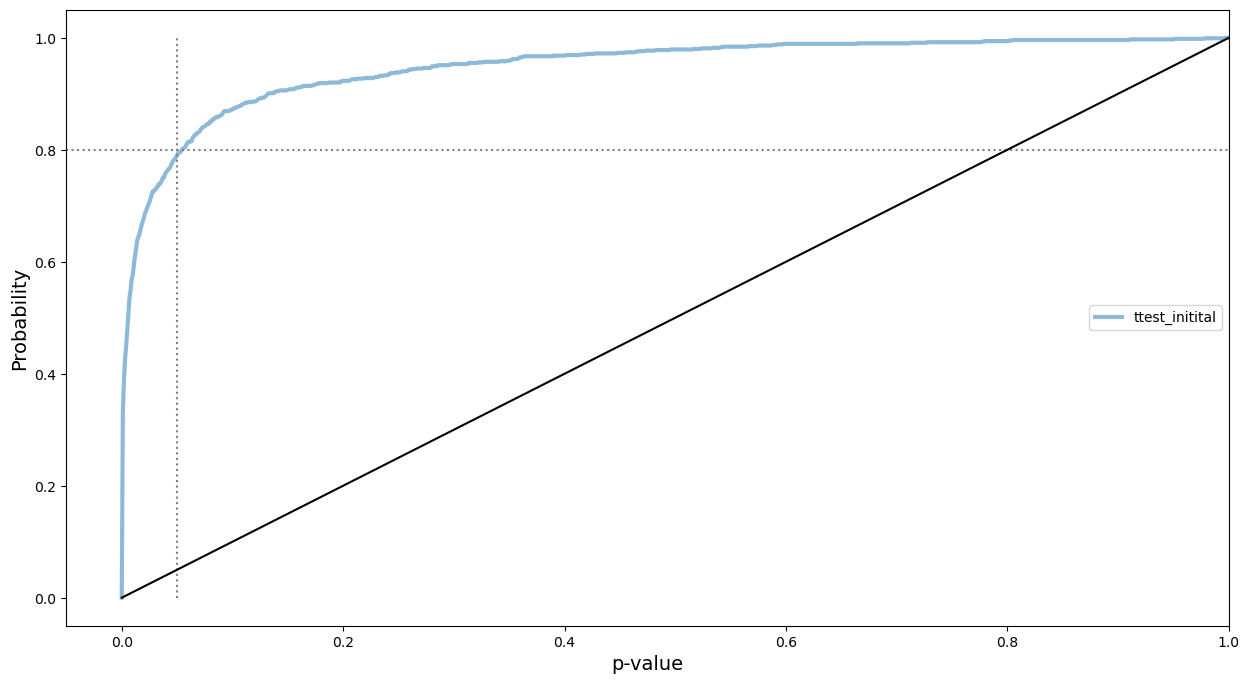

In [85]:
day=7
effect = 0.1117 # Эффект относительный 

ttl_users = math.ceil(df[(df['device']==device) & (df['reg_date'] > end_date - timedelta(days=day))]['user_id'].nunique() / num_of_bucket)
pvalues_ttest = []
for i in tqdm(range(1000)):
        df_control = df_agg.sample(n=ttl_users,replace=True)
        df_pilot = df_agg.sample(n=ttl_users,replace=True)
        
        success_control = df_control['trial_type'].sum()
        success_pilot = df_pilot['trial_type'].sum() * (1 + effect)
        n_control = len(df_control)
        n_pilot = len(df_pilot)
 
        _, p_value = proportions_ztest([success_control, success_pilot], [n_control, n_pilot])
        pvalues_ttest.append(p_value)
        
list_pvalues = [pvalues_ttest]
list_titles = ['ttest_initital']
print()
print(f"Период (дни) - {day} дней")
print(f'Итераций с p_value<0.05:',len([p for p in pvalues_ttest if p<0.05]))
print(f'Число пользователей всего:', ttl_users * 2)
plt.figure(figsize=(15,8))

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.xlabel('p-value', size=14)
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

## Критерий  t-test

100%|██████████| 1000/1000 [00:00<00:00, 1004.44it/s]



Период (дни) - 7 дней
Итераций с p_value<0.05: 838
Число пользователей всего: 6558


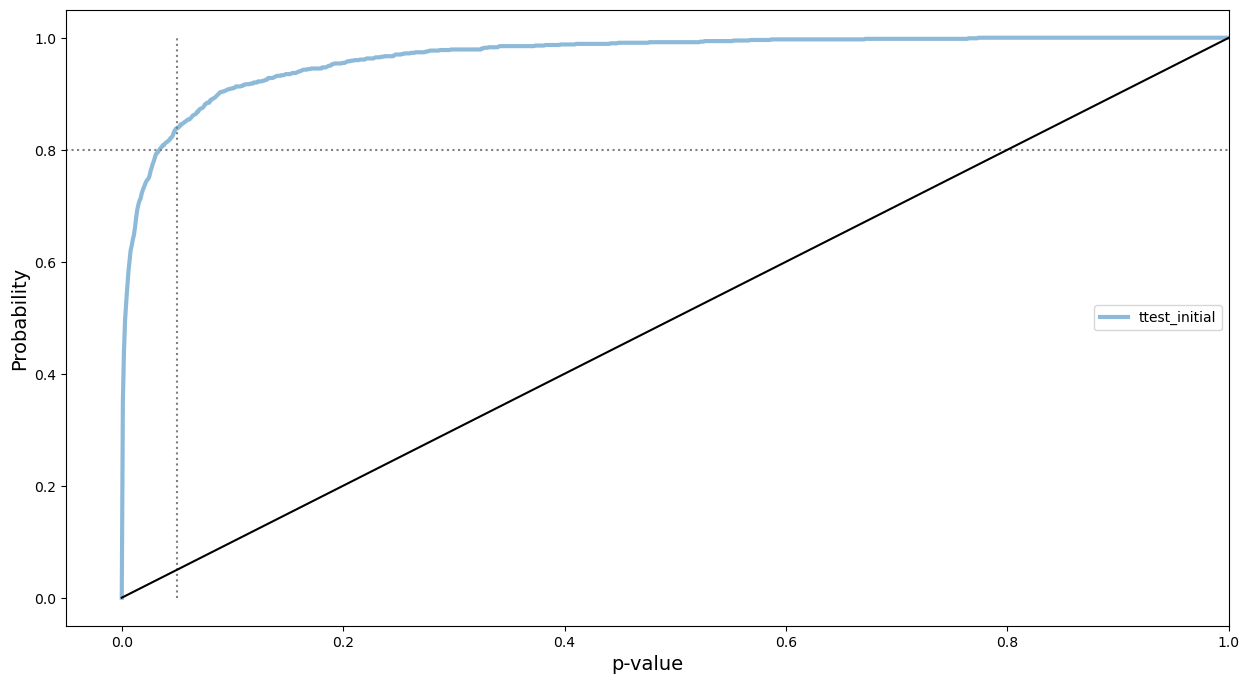

In [ ]:
day = 7
effect = 0.1237


ttl_users = math.ceil(df[(df['device'] == device) & (df['reg_date'] > end_date - timedelta(days=day))]['user_id'].nunique() / num_of_bucket)
pvalues_ttest = []
for i in tqdm(range(1000)):
    
    df_control = df_agg.sample(n=ttl_users, replace=True)
    df_pilot = df_agg.sample(n=ttl_users, replace=True)
    df_pilot = df_pilot['trial_type'] * (1 + effect)
    
    
    # Проведение t-теста
    _,p_value = ttest_ind(df_control['trial_type'], df_pilot)
    pvalues_ttest.append(p_value)
        
list_pvalues = [pvalues_ttest]
list_titles = ['ttest_initial']
print()
print(f"Период (дни) - {day} дней")
print(f'Итераций с p_value<0.05:', len([p for p in pvalues_ttest if p < 0.05]))
print(f'Число пользователей всего:', ttl_users * 2)
plt.figure(figsize=(15, 8))

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.xlabel('p-value', size=14)
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)


## t-тест с применением постстратификации

100%|██████████| 1000/1000 [00:08<00:00, 124.99it/s]

Период (дни) - 7 дней
Итераций с p_value<0.05: 193
Число пользователей всего: 6558

Среднее значение выборочных дисперсий: 0.21867233575351258
Среднее значение выборочных дисперсий с применением постратификации: 0.04206096438880093

Среднее значение выборочных средних: 0.2894682104300091
Среднее значение выборочных средних c применением постстратификации : 0.29809051235100115


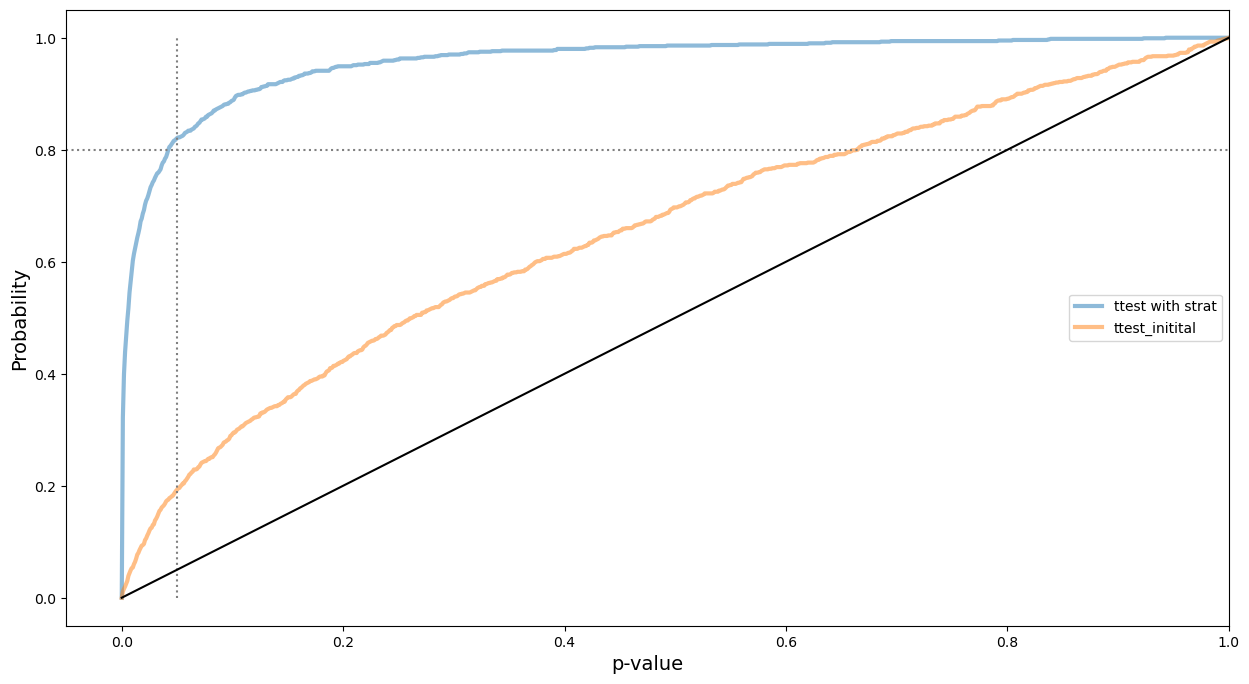

In [76]:
day = 7
effect = 0.0449

df_agg = df[(df['device'] == device) & (df['reg_date'] > end_date - timedelta(days=day))]
ttl_users = math.ceil(df_agg['user_id'].nunique() / num_of_bucket)


pvalues_ttest = []
pvalues_ttest_strat = []
var_initial = []
var_strat = []
mean_initial = []
mean_strat = []


for i in tqdm(range(1000)):
    
        df_control = df_agg.sample(n=ttl_users, replace=True)
        df_pilot = df_agg.sample(n=ttl_users, replace=True)
        df_pilot['trial_type'] = df_pilot['trial_type'] * (1 + effect)
        mean = df_pilot['trial_type'].mean()
        var = df_pilot['trial_type'].var()
        pvalue = ttest_ind(df_control['trial_type'], df_pilot['trial_type'])[1]

        
        df_control = df_agg.sample(n=ttl_users, replace=True)
        df_pilot = df_agg.sample(n=ttl_users, replace=True)
        df_pilot['trial_type'] = df_pilot['trial_type'] * (1 + effect)
        mean2 = calculate_stratified_mean(df_pilot,weights)
        var2 = calculate_strat_var(df,weights)
        pvalue_strat = check_stratified_test(df_control, df_pilot, weights)
        
    
        
        pvalues_ttest.append(pvalue)
        pvalues_ttest_strat.append(pvalue_strat)
        
        var_initial.append(var)
        var_strat.append(var2)
        
        mean_initial.append(mean)
        mean_strat.append(mean2)

list_pvalues = [pvalues_ttest, pvalues_ttest_strat]
list_titles = ['ttest_initital', 'ttest with strat',]

print(f"Период (дни) - {day} дней")
print(f'Итераций с p_value<0.05:', len([p for p in pvalues_ttest if p < 0.05]))
print(f'Число пользователей всего:', ttl_users * 2)
print()
print("Среднее значение выборочных дисперсий:",np.mean(var_initial))
print("Среднее значение выборочных дисперсий с применением постратификации:",np.mean(var_strat))  
print()
print("Среднее значение выборочных средних:",np.mean(mean_initial))
print("Среднее значение выборочных средних c применением постстратификации :",np.mean(mean_strat))

plt.figure(figsize=(15,8))

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.xlabel('p-value', size=14)
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

In [ ]:
day = 7
effects= [0, 0.1237]

# Хранение p-values для каждого значения эффекта
pvalues_dict = {}

for effect in effects:
    ttl_users = math.ceil(df[(df['device'] == device) & (df['reg_date'] > end_date - timedelta(days=day))]['user_id'].nunique() / num_of_bucket)
    pvalues_ttest = []
    
    for _ in tqdm(range(1000)):
        df_control = df_agg.sample(n=ttl_users, replace=True)
        df_pilot = df_agg.sample(n=ttl_users, replace=True)

        success_control = df_control['trial_type'].sum()
        success_pilot = df_pilot['trial_type'].sum() * (1 + effect)
        n_control = len(df_control)
        n_pilot = len(df_pilot)

        # Рассчитываем p-value через z-тест
        _, p_value = proportions_ztest([success_control, success_pilot], [n_control, n_pilot])
        pvalues_ttest.append(p_value)

    pvalues_dict[effect] = pvalues_ttest  # Сохраняем p-values для текущего эффекта

# Визуализация результатов
plt.figure(figsize=(15, 8))
X = np.linspace(0, 1, 1000)

for effect, pvalues in pvalues_dict.items():
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=f'effect = {effect}')
    print()
    print(f"Эффект = {effect}")
    print(f"Период (дни) - {day} дней")
    print(f'Итераций с p_value < 0.05:', len([p for p in pvalues if p < 0.05]))
    print(f'Число пользователей всего:', ttl_users * 2)

plt.xlabel('p-value', size=14)
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()